In [1]:
## Select desired libraries
import tensorflow as tf
from sklearn.model_selection import RepeatedKFold
import earthdata as ed

In [52]:
# Define model

# More than one hidden layers are needed for non-linear outputs
def get_model(n_inputs, n_outputs):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(20, input_dim=n_inputs, activation='relu'))
    model.add(tf.keras.layers.Dense(50, kernel_initializer='he_uniform', activation='exponential'))
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.Dense(50, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss = 'mae' , optimizer='adam')
    print(model.summary())
    return model

In [62]:
# Use model for prediction

# Clean and divide data for algorithm
# Constant definitions
DATASET_NAME = 'MODIS/006/MOD44W'  # Name of dataset to extract water bodies information
STARTING_DATE = '2000-01-01'  # First element of the dataset
ENDING_DATE = '2015-05-01'  # Last element of the dataset
BAND = 'water_mask'  # Dataset band we are interested in

# User parameters
lat, lon = 20.24, -103.06  # Center coordinates
dx = 0.8  # Rectangle length
dy = 0.3  # Rectangle width

objeto = ed.EarthData()
objeto.select_dataset(DATASET_NAME, STARTING_DATE, ENDING_DATE, BAND)
X, y, rows, columns = objeto.get_dataset(lat, lon, dx, dy)
X_t = tf.constant(X)
X_t = X_t-2000
y_t = tf.constant(y)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 20)                40        
                                                                 
 dense_52 (Dense)            (None, 50)                1050      
                                                                 
 dense_53 (Dense)            (None, 50)                2550      
                                                                 
 dense_54 (Dense)            (None, 50)                2550      
                                                                 
 dense_55 (Dense)            (None, 65395)             3335145   
                                                                 
Total params: 3,341,335
Trainable params: 3,341,335
Non-trainable params: 0
_________________________________________________________________
None


2022-06-24 16:50:59.087814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predicted: [ 1.0068377   0.9987573   1.00241    ...  0.00743528 -0.00270973
  0.00756603]


2022-06-24 16:51:04.167261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


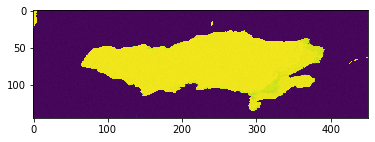

In [67]:

n_inputs, n_outputs = X_t.shape[1], y_t.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_t, y_t, verbose=0, epochs=200)
newX = tf.constant([2005-2000])
y_predicted = model.predict(newX)

print('Predicted: %s' % y_predicted[0])
ed.plot_map(y_predicted.flatten(), rows, columns)


In [68]:
print(y_predicted.max())
print(y_predicted.min())

1.0252417
-0.019588733


Predicted: [ 1.0044944   0.99649346  1.0052994  ...  0.00301905 -0.0053124
  0.01002705]
1.0181694
-0.020828132


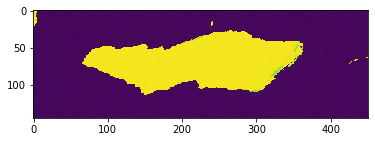

In [69]:
newX = tf.constant([2000-2000])
y_predicted = model.predict(newX)

print('Predicted: %s' % y_predicted[0])
ed.plot_map(y_predicted.flatten(), rows, columns)
print(y_predicted.max())
print(y_predicted.min())

Predicted: [ 1.0056919   0.9968696   1.0013658  ...  0.00645909 -0.00173158
  0.00642207]
1.0219743
-0.019274242


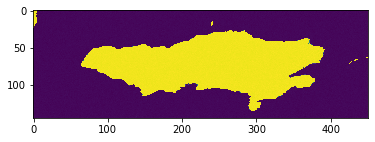

In [70]:
newX = tf.constant([2015-2000])
y_predicted = model.predict(newX)

print('Predicted: %s' % y_predicted[0])
ed.plot_map(y_predicted.flatten(), rows, columns)
print(y_predicted.max())
print(y_predicted.min())

In [7]:
# Evaluate model to test accuracy in different scenarios

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    # define evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # enumerate folds
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = tf.constant(X[train_ix]), tf.constant(X[test_ix])
        y_train, y_test = tf.constant(y[train_ix]), tf.constant(y[test_ix])
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        model.fit(X_train, y_train, verbose=0, epochs=50)
        # evaluate model on test set
        mae = model.evaluate(X_test, y_test, verbose=0)
        # store result
        print('>%.3f' % mae)
        results.append(mae)
    return results

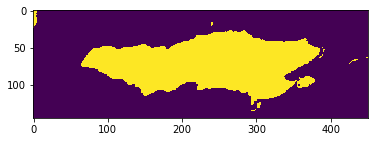

In [78]:
ed.plot_map(y[15].flatten(), rows, columns)

Predicted: [ 0.6541112   0.6486121   0.6637642  ... -0.00236933  0.0025447
  0.00827344]
0.67965275
-0.029810755


2022-06-24 16:56:42.705870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


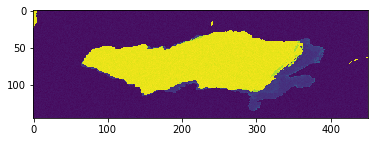

In [87]:
newX = tf.constant([1000000000000000-2000])
y_predicted = model.predict(newX)

print('Predicted: %s' % y_predicted[0])
ed.plot_map(y_predicted.flatten(), rows, columns)
print(y_predicted.max())
print(y_predicted.min())